# Linear Regression With the Pseudo Inverse

This notebook builds a simple forecasting model for telecom traffic using data collected from a real operational setting.  
The dataset contains daily measurements across different time periods within each day.  
We focus on two key signals:

- **Arrivals** (connected users)  
- **Departures** (disconnected users)

We use **Linear Regression** as a first baseline model.  
The solution is computed using the **Moore–Penrose pseudo inverse**, which gives the optimal weights in one direct mathematical step.  
This keeps the approach easy to understand and makes the notebook a good starting point before moving toward more advanced forecasting models.

We will forecast the next **100 future periods**, and we build everything needed for that inside this notebook.


## Project Description

The dataset represents telecommunication traffic measured over time.  
Each record tells us:

- The **day number** within the week (1 to 7)  
- The **period** within the day (1 to 24)  
- The **price per GB** during that period (1 or 2)  
- The amount of **Arrivals** (connected users)  
- The amount of **Departures** (disconnected users)

The goal of this project is to analyze this traffic and build a model that can forecast the next **100 periods** of both Arrivals and Departures.  
This task requires understanding the structure of the data, preparing it correctly, training a forecasting model, and evaluating how well it performs.


## What We Will Do in This Notebook

To build the forecast, we follow these steps:

1. Load and inspect the telecom traffic dataset  
2. Prepare the features by encoding categories and adding a bias term  
3. Build one shared feature matrix for both targets  
4. Split the data in time order  
5. Fit a linear regression model using the pseudo inverse  
6. Evaluate the model using MAE and RMSE  
7. Plot predictions and residuals  
8. Build the next 100 future periods  
9. Forecast Arrivals and Departures for those future periods  
10. Save the results in a clean CSV file for reporting and further analysis

This simple structure makes it easy to understand the workflow from raw data to final forecasts.


## How Linear Regression Fits the Data 

Linear regression tries to find a line (or a plane in higher dimensions) that best matches the data. It does this by choosing model weights $\beta$ that minimize the difference between the predicted and real values. 

[Image of Linear Regression best fit line]


---

### The Prediction Rule

The prediction rule is:

$$\hat{y} = X \beta$$

---

### The Optimization Goal

The goal is to make the **squared errors** as small as possible (this is the **Ordinary Least Squares** objective):

$$\min_{\beta} \| X\beta - y \|^2$$

---

### The Solution

The solution that achieves this minimum is given by the pseudo inverse:

$$\beta = X^{+} y$$

This is why we do not need iterations (like in gradient descent). The formula jumps directly to the best weights that fit the training data.

# Checking the Dataset

We load the CSV file and look at its structure.  
This helps us confirm that the columns are correct and the values are clean.

We drop any missing rows to avoid problems during model fitting.  
The dataset ends up with 500 rows and all columns are integers, which keeps things simple.


In [3]:
#imports and loading data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (10, 4)

# Load data
df = pd.read_csv("../data/telecom_traffic_data.csv")

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Season      500 non-null    int64
 1   DayOfWeek   500 non-null    int64
 2   Period      500 non-null    int64
 3   PricePerGB  500 non-null    int64
 4   Arrivals    500 non-null    int64
 5   Departures  500 non-null    int64
dtypes: int64(6)
memory usage: 23.6 KB


In [4]:
# Drop missing values if any
df = df.dropna().reset_index(drop=True)

len(df)


500

# Preparing the Feature Matrix

We build one shared feature matrix X that we will use for both Arrivals and Departures.

Period remains numeric.  
Season, DayOfWeek, and PricePerGB are turned into one hot encoded columns.  
We also add a bias term, which is just a column of ones.

In concept, X looks like this:

Period, day dummy columns, price dummy columns, season dummy columns, bias.

Using the same X for both targets makes the comparison fair and easier to interpret.


In [5]:
# Start with Period as numeric feature
X = df[["Period"]].copy()

# One hot for DayOfWeek
day_dummies = pd.get_dummies(df["DayOfWeek"], prefix="D", drop_first=True)

# One hot for PricePerGB
price_dummies = pd.get_dummies(df["PricePerGB"], prefix="P", drop_first=True)

# One hot for Season
season_dummies = pd.get_dummies(df["Season"], prefix="S", drop_first=True)

# Combine all features
X = pd.concat([X, day_dummies, price_dummies, season_dummies], axis=1)

# Add bias column
X["bias"] = 1.0

# Convert to numeric matrix
X_mat = X.to_numpy(dtype=float)

X.head()


,Period,D_2,D_3,D_4,D_5,D_6,D_7,P_2,S_2,S_3,S_4,bias
0,5,False,False,False,False,False,True,True,False,True,False,1.0
1,21,False,False,False,True,False,False,True,False,False,True,1.0
2,5,False,False,False,True,False,False,False,False,False,False,1.0
3,10,False,False,False,False,False,True,False,False,True,False,1.0
4,10,False,False,False,False,False,False,True,False,True,False,1.0


# Helper Function for Linear Regression

To avoid repeating code, we use a helper function.  
It does the following:

1. Splits the data into training and test sets, keeping the time order.  
2. Computes the pseudo inverse of the training matrix.  
3. Solves for the coefficients using  
   β = X⁺ y  
4. Makes predictions for both train and test sets.  
5. Computes the MAE, MSE, and RMSE errors.

A quick reminder:

- MAE is the average size of the errors  
- MSE squares the errors, so big mistakes count more  
- RMSE is just the square root of MSE

These numbers help us understand how well the linear model behaves.


## Why We Keep Time Order in the Split

This dataset is time based.  
If we shuffled it, the model would accidentally learn patterns from the future when trying to predict the past.

To avoid this, we split the data in order:

- First 80 percent for training  
- Last 20 percent for testing  

This gives a realistic evaluation, similar to how forecasting works in real life.


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def run_pinv_regression(X_mat, y, train_ratio=0.8, target_name="target"):
    n = len(y)
    split_idx = int(n * train_ratio)
    
    # Train and test split (time based)
    X_train = X_mat[:split_idx]
    y_train = y[:split_idx]
    X_test = X_mat[split_idx:]
    y_test = y[split_idx:]
    
    # Pseudo inverse and weights
    X_pinv = np.linalg.pinv(X_train)
    beta = X_pinv @ y_train
    
    # Predictions
    y_train_pred = X_train @ beta
    y_test_pred = X_test @ beta
    
    # Metrics
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    
    print(f"{target_name} Train MAE:", mae_train)
    print(f"{target_name} Train RMSE:", rmse_train)
    print(f"{target_name} Test MAE:", mae_test)
    print(f"{target_name} Test RMSE:", rmse_test)
    
    results = {
        "beta": beta,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred,
        "mae_train": mae_train,
        "rmse_train": rmse_train,
        "mae_test": mae_test,
        "rmse_test": rmse_test,
    }
    return results


# Forecasting Arrivals

We now run the model with Arrivals as the target.  
The coefficients we get show how each feature influences the Arrivals traffic.  
We then check the errors on both the training and testing parts of the dataset.

This gives us a first look at how the model handles normal days and busy periods.


## Understanding the Error Metrics 

We use **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)** to measure the accuracy of the model's predictions.

---

### Mean Absolute Error (MAE)

MAE tells us the **average size of the errors** in the same units as the target variable.

$$\text{MAE} = \frac{1}{n} \sum | y - \hat{y} |$$

**Interpretation:** An MAE of 5 means the model's predictions are typically off by 5 units.

---

### Root Mean Squared Error (RMSE)

RMSE punishes **large errors more strongly** due to the squaring operation inside the formula. It is often preferred when large deviations are particularly undesirable.

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum (y - \hat{y})^2}$$

**Why it matters:** It helps us see how the model behaves during sudden changes, as it heavily penalizes those big, unexpected prediction errors.

In [7]:
y_arrivals = df["Arrivals"].values

results_arr = run_pinv_regression(
    X_mat,
    y_arrivals,
    train_ratio=0.8,
    target_name="Arrivals"
)


Arrivals Train MAE: 4.743275283724531
Arrivals Train RMSE: 5.921031565661782
Arrivals Test MAE: 5.389736909874932
Arrivals Test RMSE: 6.769051912086276


# Forecasting Departures

We repeat the same steps, but this time we use Departures as the target.  
Since the feature matrix is the same, any difference in performance comes from the target itself.

Departures can behave a little differently from Arrivals, so this comparison helps us understand the patterns in both signals.


In [8]:
y_departures = df["Departures"].values

results_dep = run_pinv_regression(
    X_mat,
    y_departures,
    train_ratio=0.8,
    target_name="Departures"
)


Departures Train MAE: 4.820813116543222
Departures Train RMSE: 5.953288333011089
Departures Test MAE: 5.043302741940488
Departures Test RMSE: 6.164416596555039


# Plots for Arrivals

## Forecast vs Actual
We plot the last 100 points from the test set.  
The blue line is the real Arrivals traffic and the orange line is the prediction.  
This view makes it easy to see where the model matches the pattern and where it falls behind.


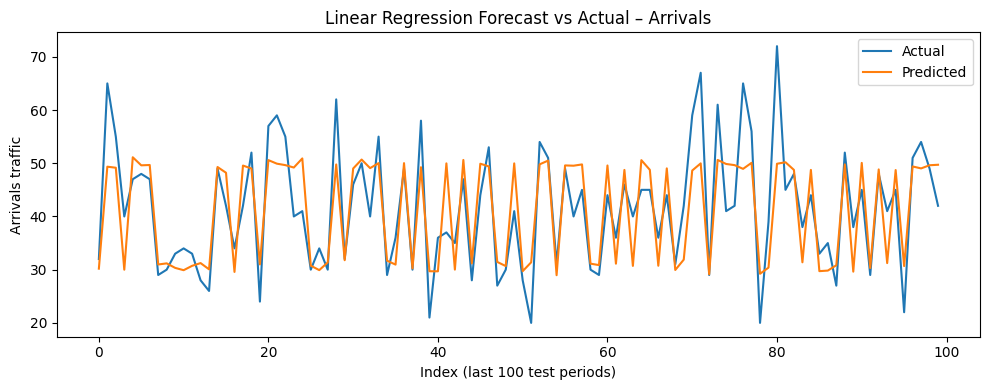

In [9]:
y_test = results_arr["y_test"]
y_test_pred = results_arr["y_test_pred"]

k = min(100, len(y_test))
y_true_plot = y_test[-k:]
y_pred_plot = y_test_pred[-k:]
idx = np.arange(k)

plt.figure()
plt.plot(idx, y_true_plot, label="Actual")
plt.plot(idx, y_pred_plot, label="Predicted")
plt.xlabel("Index (last 100 test periods)")
plt.ylabel("Arrivals traffic")
plt.title("Linear Regression Forecast vs Actual – Arrivals")
plt.legend()
plt.tight_layout()
plt.show()


### What we see here

The model follows the general movement of the Arrivals traffic.  
It stays close during calm periods but drifts a bit when the traffic jumps quickly.  
This is expected from a simple linear model since it reacts slowly to sudden changes.


## Residuals for Arrivals

Residuals ($r$) are simply the difference between the actual value ($y$) and the predicted value ($\hat{y}$):

$$r = y - \hat{y}$$

We want the residuals to stay **close to zero** without a clear pattern (e.g., no growing or shrinking spread, and no curves). If the errors grow during peak times, it means the simple linear model is not flexible enough to capture sharp changes or non-linear relationships.

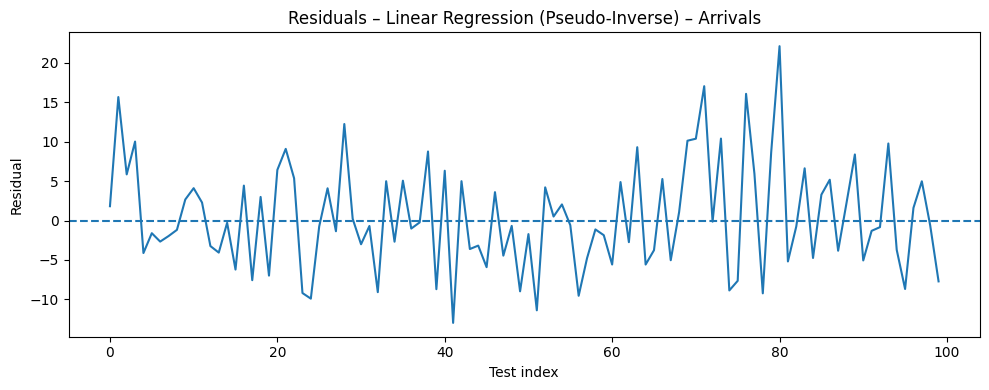

In [10]:
residuals_arr = y_test - y_test_pred

plt.figure()
plt.plot(residuals_arr)
plt.axhline(0, linestyle="--")
plt.xlabel("Test index")
plt.ylabel("Residual")
plt.title("Residuals – Linear Regression (Pseudo-Inverse) – Arrivals")
plt.tight_layout()
plt.show()


### What the residuals tell us

Most residuals are close to zero, which means the model handled the main pattern well.  
The larger spikes show where the model could not catch fast shifts in Arrivals.  
These spots are good candidates for more advanced methods later.


# Plots for Departures

## Forecast vs Actual
We plot the final 100 test points for Departures, just like we did for Arrivals.  
This helps us compare how both targets react to the same features.


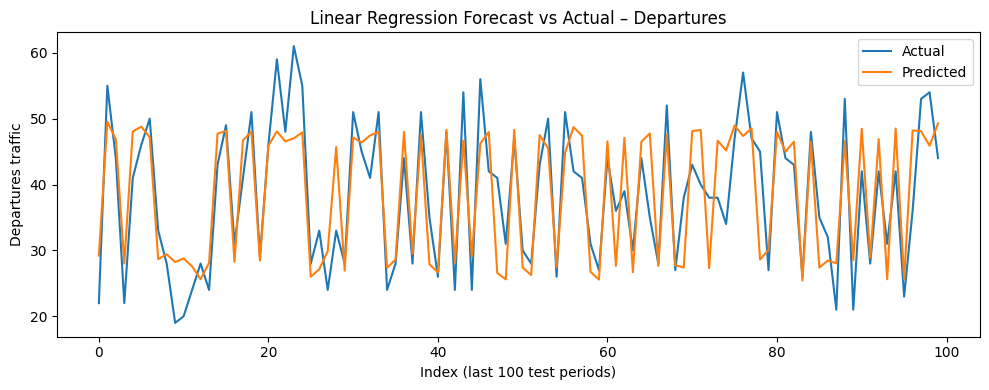

In [11]:
y_test_d = results_dep["y_test"]
y_test_pred_d = results_dep["y_test_pred"]

k_d = min(100, len(y_test_d))
y_true_plot_d = y_test_d[-k_d:]
y_pred_plot_d = y_test_pred_d[-k_d:]
idx_d = np.arange(k_d)

plt.figure()
plt.plot(idx_d, y_true_plot_d, label="Actual")
plt.plot(idx_d, y_pred_plot_d, label="Predicted")
plt.xlabel("Index (last 100 test periods)")
plt.ylabel("Departures traffic")
plt.title("Linear Regression Forecast vs Actual – Departures")
plt.legend()
plt.tight_layout()
plt.show()


### Reading this plot

The Departures pattern is a little noisier than Arrivals.  
The model still tracks the overall shape, but the gaps between actual and predicted values appear a bit more often.  
This lines up with the higher error values we saw earlier.


## Residuals for Departures

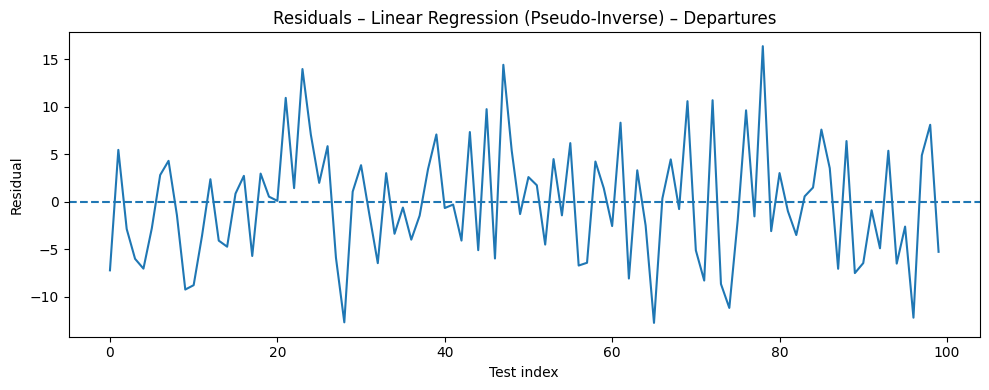

In [23]:
residuals_dep = y_test_d - y_test_pred_d

plt.figure()
plt.plot(residuals_dep)
plt.axhline(0, linestyle="--")
plt.xlabel("Test index")
plt.ylabel("Residual")
plt.title("Residuals – Linear Regression (Pseudo-Inverse) – Departures")
plt.tight_layout()
plt.show()


### Residual insight

The residuals bounce around zero without a strong pattern, which is a good sign.  
There are a few larger swings compared to the Arrivals case, which matches the idea that Departures are harder for a simple linear model to capture.


# Why We Forecast the Next 100 Periods

The dataset gives us the complete history up to the current day.  
Our task is to generate predictions for the next 100 future periods using only the features available:

- Season  
- DayOfWeek  
- Period  
- PricePerGB  

We build a future table that repeats the natural cycles of these variables.  
The model then uses this table to compute:

$$\hat{y}_{t+1}, \hat{y}_{t+2}, \ldots, \hat{y}_{t+100}$$

for both Arrivals and Departures.

# Building Future Periods for Forecasting

We create a table for the next 100 periods using simple patterns for Season, DayOfWeek, Period, and PricePerGB.  
This table follows the same structure as the original dataset so it can be encoded in the same way.

This step prepares the input needed for forecasting the next 100 values for both Arrivals and Departures.

In [24]:
# Build future 100 periods table (Season, DayOfWeek, Period, PricePerGB)

future_steps = 100

last_row = df.iloc[-1]

future_periods = []
future_days = []
future_prices = []
future_seasons = []

for i in range(1, future_steps + 1):
    # Period cycles 1–24
    next_period = (last_row["Period"] + i - 1) % 24 + 1
    future_periods.append(next_period)
    
    # DayOfWeek cycles 1–7
    next_day = (last_row["DayOfWeek"] + i - 1) % 7 + 1
    future_days.append(next_day)
    
    # Keep PricePerGB same as last known (simple assumption)
    future_prices.append(last_row["PricePerGB"])
    
    # Season cycles 1–4 (very simple pattern)
    next_season = (last_row["Season"] + (i // 24)) % 4 + 1
    future_seasons.append(next_season)

future_df = pd.DataFrame({
    "Season": future_seasons,
    "DayOfWeek": future_days,
    "Period": future_periods,
    "PricePerGB": future_prices
})

future_df.head()


,Season,DayOfWeek,Period,PricePerGB
0,1,1,19,1
1,1,2,20,1
2,1,3,21,1
3,1,4,22,1
4,1,5,23,1


# Forecasting the Next 100 Points

We build X_future with the same encoding as the original X.  
After aligning the columns, we apply the learned coefficients for Arrivals and Departures.

The output gives us the next 100 predicted values for both targets, which we save in a CSV file.

In [25]:
# Build X_future with the same encoding as X

Xf = future_df[["Period"]].copy()

day_dummies_f = pd.get_dummies(future_df["DayOfWeek"], prefix="D", drop_first=True)
price_dummies_f = pd.get_dummies(future_df["PricePerGB"], prefix="P", drop_first=True)
season_dummies_f = pd.get_dummies(future_df["Season"], prefix="S", drop_first=True)

Xf = pd.concat([Xf, day_dummies_f, price_dummies_f, season_dummies_f], axis=1)

Xf["bias"] = 1.0

# Make sure columns match the original X (missing ones are filled with 0)
Xf = Xf.reindex(columns=X.columns, fill_value=0)

X_future = Xf.to_numpy(dtype=float)

Xf.head()


,Period,D_2,D_3,D_4,D_5,D_6,D_7,P_2,S_2,S_3,S_4,bias
0,19,False,False,False,False,False,False,0,False,False,False,1.0
1,20,True,False,False,False,False,False,0,False,False,False,1.0
2,21,False,True,False,False,False,False,0,False,False,False,1.0
3,22,False,False,True,False,False,False,0,False,False,False,1.0
4,23,False,False,False,True,False,False,0,False,False,False,1.0


In [26]:
# Forecast next 100 periods using the learned linear regression models

beta_arr = results_arr["beta"]
beta_dep = results_dep["beta"]

future_arrivals = X_future @ beta_arr
future_departures = X_future @ beta_dep


In [27]:
# Build final forecast table for linear regression and save

forecast_arrivals_int = np.round(future_arrivals).astype(int)
forecast_departures_int = np.round(future_departures).astype(int)

forecast_lr_df = future_df.copy()
forecast_lr_df["Arrivals_Forecast_LR"] = forecast_arrivals_int
forecast_lr_df["Departures_Forecast_LR"] = forecast_departures_int

forecast_lr_df.head()


,Season,DayOfWeek,Period,PricePerGB,Arrivals_Forecast_LR,Departures_Forecast_LR
0,1,1,19,1,49,46
1,1,2,20,1,50,46
2,1,3,21,1,48,47
3,1,4,22,1,49,47
4,1,5,23,1,50,45


In [2]:
# Expor to a CSV file
forecast_lr_df.to_csv("../results/telecom_forecasting_linear_regression_100periods.csv", index=False)

print("saved the CSV file")

NameError: name 'forecast_lr_df' is not defined

# Discussion of Results

The linear model captured the general trend in both Arrivals and Departures.  
It handled slow changes well, but it struggled with sudden jumps, which is expected.  
Arrivals were slightly smoother, so the model performed a bit better there.  
Departures had more noise, leading to slightly higher errors.  
Even with this, the results give us a solid baseline for comparing more advanced models later.


---

This notebook completes the baseline forecasting task using a simple linear model.  
The results help us understand the shape of the data and how predictable each target is.  
This also gives us a clear reference point for more advanced methods we might explore later, such as autoregressive models or neural networks.


# Summary

We built a clear baseline model for forecasting Arrivals and Departures.  
The same feature matrix was used for both targets, and the pseudo inverse gave us a direct solution for the linear regression.  
The results give us a good starting point for the next forecasting approaches such as AR models and neural networks.

---

### Prepared by  
**Zahid Sami Alabadllah and group members**   
BSc. Computer Science, KFUPM  

Email: Zahid.Alabadllah@hotmail.com  
LinkedIn: www.linkedin.com/in/zahid-alabadllah  
GitHub Repository: https://github.com/Zahid-Alabadllah  

All rights reserved, 2025.
